# Question 1: Active Learning

In [9]:
import numpy as np
from pathlib import Path
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

FIG_DIR = Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
BATCH_SIZE = 5
NUM_ITER = 100

### Obtain, process and partition the data set

In [10]:
d = fetch_openml('usps', version=2, as_frame=False)  
Xall = np.asarray(d['data'], dtype=np.float32)
Yall = np.asarray(d['target'], dtype=np.int32)-1
Xall = (Xall - np.mean(Xall,axis=0))/np.std(Xall,axis=0)

Xlearn, Xte, Ylearn, Yte,= train_test_split(Xall, Yall, test_size=0.2,shuffle=True,stratify=Yall,random_state=1)
Xtr   = Xlearn[:100]
Ytr   = Ylearn[:100]
Xpool = Xlearn[100:]
Ypool = Ylearn[100:]

### Question 1(a): Random acquisition function

In [11]:
def random_acquisition(Xpool, classifier, batch_size=5):
    """ Selects batch_size data cases from Xpool to acquire at random.
    Parameters
    ----------
    Xpool : np.array of shape (N,D) containing unlabeled pool
    classifier : trained scikit-learn classifier support predict_proba method
    batch_size : int, number of instances to acquire

    Returns
    -------
    List of randomly selected indices of data cases from Xpool to acquire. 
    For example, if batch_size=2 and N=100, this function might return [17, 83]
    indicating the labels should be acquired for the data cases Xpool[17,:] and 
    Xpool[83,:]
    """
    npool = Xpool.shape[0]
    if npool == 0:
        return []

    batch_size = min(batch_size, npool)
    index_list = np.random.choice(npool, size=batch_size, replace=False).tolist()
    return index_list

### Question 1(b): Entropy acquisition function

In [12]:
def entropy_acquisition(Xpool, classifier, batch_size=5):
    """ Selects the batch_size data cases from Xpool that have the highest entropy.
    according to the provided classifier.

    Parameters
    ----------
    Xpool : np.array of shape (N,D)
        unlabeled pool feature vectors
    classifier : scikit-learn classifier instance 
        must be trained and support predict_proba method
    batch_size : int
        number of instances to acquire

    Returns
    -------
    List of indices of the batch_size data cases from Xpool that have the
    highest entropy values. For example, if batch_size=2 and N=100, this function
    should return the indices of the two data cases with the highest entropy
    according to the provided classifer. If the two data cases with the highest
    entropy are Xpool[42,:] and  Xpool[589,:], this function should return
    [42, 589].
    """
    npool = Xpool.shape[0]
    if npool == 0:
        return []

    batch_size = min(batch_size, npool)
    probs = classifier.predict_proba(Xpool)
    eps = 1e-12
    entropies = -np.sum(probs * np.log(probs + eps), axis=1)
    entropy_index_list = np.argsort(entropies)[-batch_size:][::-1].tolist()
    return entropy_index_list

### Question 1(c) Labeling Oracle

In [13]:
def labeling_oracle(Xtr, Ytr, Xpool, Ypool, inds):
    """This function simulates a labeling oracle. Given the 
    list of pool data case indices to acquire labels for inds, it 
    removes the corresponding feature vectors from Xpool and 
    adds them to Xtr. It similarly removes the labels from Ypool
    and adds them to Ytr. It returns the updated training and pool
    data arrays.

    Parameters
    ----------
    Xtr : np.array of shape (Ntr,D)
        initial training feature vectors
    Ylabeled : np.array of shape (Ntr,)
        initial training labels
    Xpool : np.array of shape (Npool,D)
        initial unlabeled pool feature vectors
    Ypool : np.array of shape (Npool,)
        labels for the initial pool cases. Held out from training.
    inds : list of int
        The indices of the data cases to remove from the pool, label, 
        and add to the training set. 
    """
    if len(inds) == 0:
        return Xtr, Ytr, Xpool, Ypool

    inds = np.unique(np.asarray(inds, dtype=int))
    X1,  Y1 = Xpool[inds], Ypool[inds]

    if Xtr.size == 0:
        Xtr_new = X1.copy()
    else:
        Xtr_new = np.vstack([Xtr, X1])

    Ytr_new = np.concatenate([Ytr, Y1])

    mask = np.ones(Xpool.shape[0], dtype=bool)
    mask[inds] = False
    Xp_new, Yp_new = Xpool[mask], Ypool[mask]

    return Xtr_new, Ytr_new, Xp_new, Yp_new

### Question 1(d) Active Learning Loop

In [14]:
def active_learning_loop(Xtr, Ytr, Xpool, Ypool, Xtest, Ytest, acquisition_function, num_iter=100, batch_size=5):
    """This function runs num_iter active learning iterations strting from 
    the provided labeled data set and unlabeled pool. batch_size data cases 
    are aquired using the provided acquisition_function on each iteration

    Parameters
    ----------
    Xtr : np.array of shape (Ntr,D)
        initial training feature vectors
    Ytr : np.array of shape (Ntr,)
        initial training labels
    Xpool : np.array of shape (Npool,D)
        initial unlabeled pool feature vectors
    Ypool : np.array of shape (Npool,)
        labels for the initial pool cases. Held out from training.
    Xtest : np.array of shape (Nte,D)
        test set feature vectors
    Ytest : np.array of shape (Nte,)
        test set labels
    acuisition_function : function
        a function taking Xpool, classifier, batch_size arguments and
        returning indices of data cases to acquire.
    num_iter : int, optional
        number of active learning iterations to perform, by default 100
    batch : int, optional
        number of labels to acquire on each iteration, by default 5
    """

    Xtr1, Ytr1, Xpool1, Ypool1 = np.array(Xtr, copy=True), np.array(Ytr, copy=True), np.array(Xpool, copy=True), np.array(Ypool, copy=True)
    errors = []

    for i in range(num_iter):
        classifier = LogisticRegression(max_iter=1000, multi_class='multinomial')
        classifier.fit(Xtr1, Ytr1)
        err = 1.0 - classifier.score(Xtest, Ytest)
        errors.append(err)

        if Xpool1.shape[0] == 0:
            break

        batch = min(batch_size, Xpool1.shape[0])
        inds = acquisition_function(Xpool1, classifier, batch_size=batch)
        Xtr1, Ytr1, Xpool1, Ypool1 = labeling_oracle(
            Xtr1, Ytr1, Xpool1, Ypool1, inds
        )

    return errors

### Question 1(e) Active Learning Experiment 

In [15]:
errs_rand = active_learning_loop(Xtr, Ytr, Xpool, Ypool, Xte, Yte, random_acquisition, num_iter=100, batch_size=5)
errs_ent  = active_learning_loop(Xtr, Ytr, Xpool, Ypool, Xte, Yte, entropy_acquisition, num_iter=100, batch_size=5)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

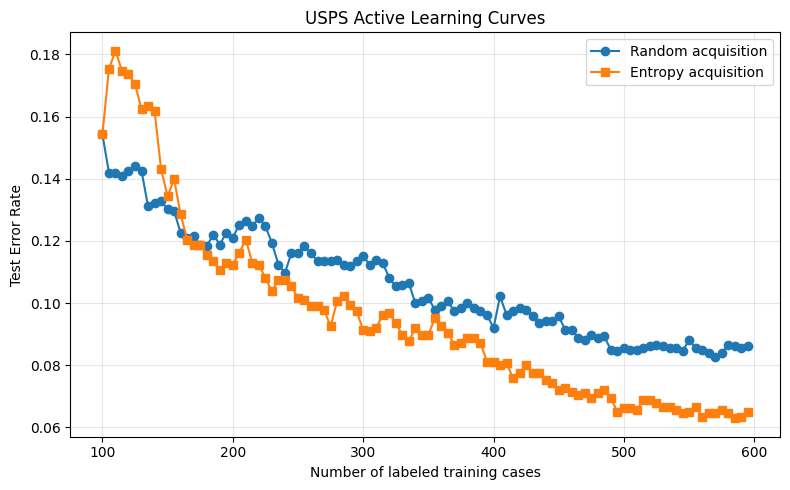

In [16]:
if errs_rand and errs_ent:
    initial_train_size = Xtr.shape[0]
    sizes_rand = initial_train_size + np.arange(len(errs_rand)) * BATCH_SIZE
    sizes_ent = initial_train_size + np.arange(len(errs_ent)) * BATCH_SIZE

    plt.figure(figsize=(8, 5))
    plt.plot(sizes_rand, errs_rand, marker='o', label='Random acquisition')
    plt.plot(sizes_ent, errs_ent, marker='s', label='Entropy acquisition')
    plt.xlabel('Number of labeled training cases')
    plt.ylabel('Test Error Rate')
    plt.title('USPS Active Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    raise RuntimeError('No error traces found')
